# 👀 WARNING 🐈


### ⚠️ Important Setup Instructions

Before you begin this homework, please note that all tasks were tested in Google Colab. It's crucial to follow the setup steps below to ensure that your environment is configured correctly. You will require a GPU for some of the tasks, so please make sure to adjust your Colab settings accordingly.

#### Setup Steps:

1. Use a GPU runtime to accelerate the training process of the CNN and proper compile:
   - In Google Colab, click on ‘Runtime’.
   - Select ‘Change runtime type’.
   - Choose ‘GPU’ from the hardware accelerator dropdown menu.
2. Install necessary libraries and dependencies as outlined in the provided code snippets.
3. Execute all code cells in the order they are presented to avoid dependency issues.

#### Installation Commands:

# SETUP

In [ ]:
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig "/usr/lib64-nvidia"

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link



In [ ]:
!pip install tensorrt torch_tensorrt onnx onnxruntime maturin torchvision

In [ ]:
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y

info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: default toolchain set to 'stable-x86_64-unknown-linux-gnu'

  stable-x86_64-unknown-linux-gnu unchanged - rustc 1.74.1 (a28077b28 2023-12-04)


Rust is installed now. Great!

To get started you may need to restart your current shell.
This would reload your PATH environment variable to include
Cargo's bin directory ($HOME/.cargo/bin).

To configure your current shell, run:
source "$HOME/.cargo/env"


In [ ]:
import os
os.environ['PATH'] += ":/root/.cargo/bin"

In [ ]:
!cargo --version

cargo 1.74.1 (ecb9851af 2023-10-18)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# HSE 2023: Mathematical Methods for Data Analysis

# Homework 6 (Bonus)

**Author: Alexander Kalashnikov**

## Introduction
Welcome to an exciting journey through the realms of machine learning and system integration, where we will tackle a fascinating challenge: building a Convolutional Neural Network (CNN) designed to recognize time from images of digital clocks. This task not only covers the design and training of neural networks but also extends into the world of production-level deployment. We'll dive into converting a trained model into various runtimes, and you'll get hands-on experience with implementing model inference in Rust—a language renowned for its performance and safety.

<img src="/content/drive/MyDrive/hw6/images/1.png">

---

<div align="center"><b> Your mission is to train a model that can look at such images and tell us the time displayed. </b></div>

---

# Load data

Let's begin by downloading the dataset required for this homework. The dataset contains the images that we will use to train our model.

**Follow the commands below to download and extract the dataset into your working environment:**

In [ ]:
!gdown --id 1ZLKpoYcMVBVgZBq2jvB23zR4yHClVfUd && unzip -q -o timer_dataset.zip
!echo "Downloaded data into ./timer_dataset"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZLKpoYcMVBVgZBq2jvB23zR4yHClVfUd
To: /content/timer_dataset.zip
100% 18.9M/18.9M [00:00<00:00, 72.1MB/s]
Downloaded data into ./timer_dataset


### Below are two utility functions for the start:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [ ]:
def read_image(image_path: str) -> np.ndarray:
    """
    Reads an image from a specified file path and convert it to RGB format.

    Args:
        image_path (str): The path to the image file.

    Returns:
        np.ndarray: The image in RGB format.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def visualize(**images) -> None:
    """
    Plots images in one row.

    Args:
        **images: Variable length keyword arguments. Each key-value pair should be
                  the name of the image and the image data respectively.

    """
    n = len(images)

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


## [Task 1] Exploratory Data Analysis (EDA) - 0.5 Point

### Objective:
Perform an exploratory data analysis (EDA) on the provided dataset to understand its structure, contents, and the data you'll be working with.

### Instructions:

1. **Verify Dataset Integrity:**
   - Check dataset structure.
   - Check the number of files in the dataset.

2. **Understand File Distribution:**
   - List the first few image filenames to get a sense of the naming convention.
   - Review the targets file to understand the association between images and their labels.

3. **Read Targets:**
   - Use pandas to read the targets file into a DataFrame.
   - Ensure the DataFrame is correctly structured with columns for both the target and the filename.

4. **Data Visualization:**
   - Use the `read_image` function to read a sample image from the dataset.
   - Visualize the sample image using the `visualize` function.
   - Map this sample image to the corresponding target in targets DataFrame printing both.

5. **Initial Data Insights:**
   - Report the size of the dataset (number of images).
   - Provide a brief summary of the target variable distribution.

In [ ]:
from pathlib import Path

IMAGES_FOLDER = Path("timer_dataset/images")

In [ ]:
len(list(IMAGES_FOLDER.iterdir()))

1296

In [ ]:
import os

def verify_dataset_integrity(dataset_path):
    # Check if path exists
    if not os.path.exists(dataset_path):
        print("Dataset path does not exist.")
        return

    # Check if path is a directory
    if not os.path.isdir(dataset_path):
        print("The path is not a directory")
        return

    # Get a list of files in the directory
    files = os.listdir(dataset_path)

    # Count the number of image files by checking their extensions (assuming .jpg, .png, etc.)
    image_files = [file for file in files if file.lower().endswith(('jpg', 'jpeg', 'png'))]

    print(f"Number of image files in the dataset: {len(image_files)}")

    return image_files

dataset_path = IMAGES_FOLDER
image_files = verify_dataset_integrity(dataset_path)

Number of image files in the dataset: 1296


In [ ]:
def understand_file_distribution(image_files):
    # List the first few filenames
    print("First few image filenames:")
    for filename in image_files[:5]:
        print(filename)

# Call the function, assuming you have verified the dataset and have image_files
understand_file_distribution(image_files)


First few image filenames:
ff6802020121ffff.png
ff1808caa088fcff.png
ff1a008262007eff.png
ff0800a81808cfff.png
ff1808082808ffff.png


In [ ]:
import pandas as pd

def read_targets(targets_file_path):
    targets_df = pd.read_csv(targets_file_path, sep=' -> ', header=None, names=["target", "filename"])
    print(targets_df.head())  # display the first few rows
    return targets_df

targets_file_path = 'timer_dataset/targets.txt'
targets_df = read_targets(targets_file_path)

  target              filename
0  21:57  ff1006a258017fff.png
1  19:52  ff1006828880feff.png
2  12:16  ff1800a81888cfff.png
3  23:49  ff18088870087fff.png
4  11:16  ff1800a81828ffff.png


<ipython-input-50-0728f4802ae7>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  targets_df = pd.read_csv(targets_file_path, sep=' -> ', header=None, names=["target", "filename"])


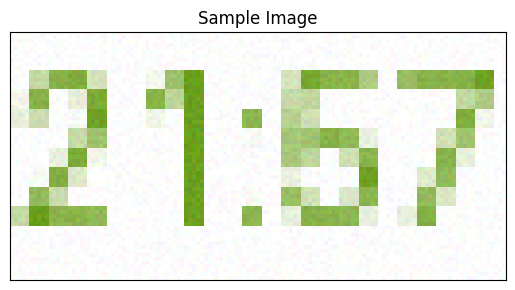

The label for the image ff1006a258017fff.png is: 21:57


In [ ]:
sample_image_path = os.path.join(dataset_path, targets_df["filename"][0])
sample_image = read_image(sample_image_path)
visualize(sample_image=sample_image)

print(f"The label for the image {targets_df['filename'][0]} is: {targets_df['target'][0]}")

In [ ]:
def initial_data_insights(targets_df):
    # Dataset size
    number_of_images = targets_df.shape[0]
    print(f"Number of images: {number_of_images}")

    # Summary of the target variable distribution
    print("Target variable distribution:")
    print(targets_df['target'].value_counts())

initial_data_insights(targets_df)


Number of images: 1296
Target variable distribution:
15:34    5
02:42    4
17:32    4
14:07    4
23:21    4
        ..
14:13    1
20:11    1
21:45    1
21:44    1
02:45    1
Name: target, Length: 948, dtype: int64


## [Task 2] Implement `create_train_val_splits` Function - 0.25 Points

### Objective:
Write a Python function `create_train_val_splits` to divide a dataset into training and validation sets and save the result as a JSON file.

### Requirements:

- Read image names from a markup file (`markup_path`).
- Split data into training and validation sets using the `val_ratio`.
- Save the splits in JSON format to the specified `output_path`.

In [ ]:
import json

from sklearn.model_selection import train_test_split


def create_train_val_splits(
    markup_path: str,
    output_path: str,
    val_ratio: float = 0.2,
) -> None:
    """
    Creates training and validation splits from a markup file and save them as a JSON file.

    This function reads a markup file containing image names, splits the images into
    training and validation sets, and then saves these sets to a specified JSON file.

    Args:
        markup_path (str): Path to the markup file with image names.
        output_path (str): Path where the JSON file with train-validation splits will be saved.
        val_ratio (float, optional): The proportion of the dataset to include
        in the validation split. Defaults to 0.2.
    """
    filenames = read_targets(markup_path)["filename"]
    train_files, val_files = train_test_split(filenames, test_size=val_ratio, random_state=42)
    with open(output_path, 'w') as fp:
        json.dump({
            "train": [*train_files],
            "validation": [*val_files]
        }, fp)


markup_path = 'timer_dataset/targets.txt'
output_path = 'timer_dataset/splits.json'
create_train_val_splits(markup_path, output_path)

<ipython-input-50-0728f4802ae7>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  targets_df = pd.read_csv(targets_file_path, sep=' -> ', header=None, names=["target", "filename"])


  target              filename
0  21:57  ff1006a258017fff.png
1  19:52  ff1006828880feff.png
2  12:16  ff1800a81888cfff.png
3  23:49  ff18088870087fff.png
4  11:16  ff1800a81828ffff.png


## [Task 3] Image Preprocessing and Augmentation - 1 Point

<img src="./images/2.png" width="60%">

### Objective:
Implement functions to apply image augmentations and preprocessing for the images normalization and unification.

### Part 1: Define Augmentation Functions


- `get_training_augmentations(image_size: int) -> albu.Compose`: This function should construct a series of augmentation transforms for training images. You have the freedom to add any augmentations you find necessary to improve the training process. **However, ensure that every transformed image is resized to a square format with dimensions `image_size x image_size`.**


- `get_validation_augmentations(image_size: int) -> albu.Compose`: This function will define a series of transformations for validation images. Validation transforms are typically less extensive than training transforms. They should normalize the image but should not include random transformations that would create variations in your validation data. Like the training augmentations, **all images should be resized to be square with the same width and height as specified by `image_size`.**

Note that while you may introduce a variety of transformations for the training dataset to improve model robustness, all images, after augmentation, should maintain a square shape. This consistency is crucial for training stability and performance evaluation.

In [ ]:
from typing import Callable, Literal

import albumentations as albu


def get_training_augmentations(image_size: int) -> albu.Compose:
    """
    Constructs augmentation transform for training images.

    Returns:
        albu.Compose: augmentation transform
    """
    return albu.Compose([
        albu.Resize(image_size, image_size),
        albu.ColorJitter(),
        albu.Rotate(20)
    ])


def get_validation_augmentations(image_size: int) -> albu.Compose:
    """
    Constructs augmentation transform for validation images.

    Returns:
        albu.Compose: augmentation transform
    """
    return albu.Compose([
        albu.Resize(image_size, image_size)
    ])

### Part 2: Implement `to_tensor` Function
Implement the `to_tensor` function to reshape the input image to the required format for PyTorch models (**CxHxW** - channel first), which involves changing the order of dimensions and ensuring the data type is float32.

In [ ]:
def to_tensor(image: np.ndarray, **kwargs) -> np.ndarray:
    """
    Transposes an image array to the required shape for pytorch.

    Args:
        x (np.ndarray): image array.

    Returns:
        np.ndarray: transposed image array
    """
    a = np.float32(np.transpose(np.array(image), (2, 0, 1)))
    #print(a)
    return a

### Part 3: Implement `normalize_img` Function
Write the `normalize_img` function to apply mean and standard deviation normalization to the image data, which is a common preprocessing step to standardize input data for model training.

**Use the mean and the standard deviation values for the ImageNet dataset. Do not forget about the image normalization by maximum pixel value.**

In [ ]:
def normalize_img(image: np.ndarray, **kwargs) -> np.ndarray:
    """
    Normalizes image data.

    Args:
        img (np.ndarray): image array.

    Returns:
        np.ndarray: normalized image array
    """
    #print(image)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image /= 255
    return (image - mean) / std

### Part 4: Construct Preprocessing Pipeline
Combine the normalization and tensor transformation into a preprocessing pipeline with the `get_preprocessing` function, which should return an `albu.Compose` pipeline to be applied to image data before feeding it into the model.

In [ ]:
def get_preprocessing() -> albu.Compose:
    """
    Constructs preprocessing transform.

    Args:
        preprocessing_fn (Callable): data normalization function.

    Returns:
        albu.Compose: preprocessing transform
    """
    return albu.Compose([
        to_tensor,
        normalize_img
    ])

## [Task 4] Custom Dataset Class Implementation - 1 Point

### Description:
Construct a `TimerDataset` class extending PyTorch's `Dataset` class, capable of loading, processing, and augmenting timer images for model training.

### Steps:
1. Initialize the dataset with paths for images, markup, and splits, specifying data kind (train/validation), and optional augmentation and preprocessing functions.
2. Load dataset splits from a JSON file and image-label pairs from a markup file.
3. Implement `one_hot_encode` to encode targets as OH vectors.
4. Implement `__getitem__` to load and preprocess images, and apply one-hot encoding to labels.

In [ ]:
import json
import random
from pathlib import Path
from typing import Callable, Literal

import torch
from torch.utils.data import Dataset
from torch.nn.functional import one_hot


class TimerDataset(Dataset):
    """
    Custom dataset class for loading and processing timer images.

    This dataset class is designed to work with a specific format of markup file and
    directory structure. It supports optional data augmentation and preprocessing.
    Labels are one-hot encoded.

    Args:
        images_path (Path): Path to the directory containing images.
        markup_path (Path): Path to the markup file containing image names and corresponding time labels.
        splits_path (Path): Path to the JSON file containing train/validation splits.
        kind (str): Type of dataset to load ('train' or 'validation').
        augmentations (Callable, optional): A function/callable that applies data augmentation.
        preprocessing (Callable, optional): A function/callable that applies preprocessing.

    """
    def __init__(
        self,
        images_path: Path,
        markup_path: Path,
        splits_path: Path,
        kind: Literal["train", "validation"],
        augmentations: Callable | None = None,
        preprocessing: Callable | None = None,
    ):
        self.images_path = images_path
        self.augmentation = augmentations
        self.preprocessing = preprocessing

        # Load splits
        with open(splits_path, 'r') as fp:
            data = json.load(fp)[kind]

        # Load markup (image_name, (hours, minutes))
        self.samples: list[tuple[str, tuple[int, int]]] = []
        df = read_targets(markup_path)
        for index, row in df.iterrows():
            splits = row["target"].split(":")
            self.samples.append((row["filename"], (int(splits[0]), int(splits[1]))))

    def __len__(self):
        return len(self.samples)

    def one_hot_encode(self, time: tuple[int, int]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        One-hot encodes the given time.

        Args:
            time (tuple[int, int]): A tuple containing hours and minutes.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: One-hot encoded hour and minute tensors.
        """
        hours = torch.zeros(24)
        minutes = torch.zeros(60)
        hours[time[0]] = 1
        minutes[time[1]] = 1
        return (hours, minutes)

    def __getitem__(self, idx: int) -> tuple[np.ndarray, tuple[int, int]]:
        image_name, time = self.samples[idx]
        image_path = self.images_path + '/' + image_name

        # Load image with OpenCV and convert to RGB
        image = read_image(image_path)

        # Apply augmentations
        if self.augmentation is not None:
            image = self.augmentation(image=image)

        # Apply preprocessing
        if self.preprocessing is not None:
            #image = self.preprocessing(image=image)
            image = to_tensor(normalize_img(np.float32(image["image"])))

        # One-hot encode the label
        hour_label, minute_label = self.one_hot_encode(time)

        return image, (hour_label, minute_label)


### Testing:
- Instantiate the `TimerDataset` class.
- Retrieve and visualize a sample from the dataset to confirm correct loading and processing.

In [ ]:
dataset = TimerDataset(images_path="timer_dataset/images",
                       markup_path="timer_dataset/targets.txt",
                       splits_path="timer_dataset/splits.json",
                       kind='train')#, augmentations=get_training_augmentations(128), preprocessing=get_preprocessing())

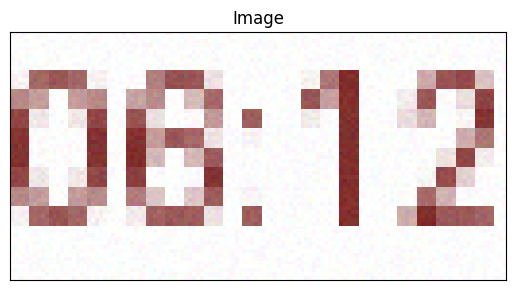

In [ ]:
visualize(image=dataset[0][0])

## [Task 5] Two-Headed CNN Model Architecture - 1 Point

<img src="./images/3.png" width="65%">

### Description:
Design a neural network with a shared backbone and two separate heads for predicting hours and minutes.

### Steps:
1. Use a pre-trained CNN from `torchvision` to retrieve images features.
2. Add two new heads, one for hour classification and one for minute classification, each with its own fully connected layers.
3. Implement the `forward` method to process input through the backbone and both heads.

In [ ]:
import torch
import torch.nn as nn


class TwoHeadedCNN(nn.Module):
    """
    A neural network module with two heads,
    designed for simultaneous hour and minute classification.

    This module takes a backbone CNN model,
    removes its last fully connected layer, and adds two separate
    heads: one for hour classification and one for minute classification.

    Args:
        backbone (torch.nn.Module): A pre-trained CNN model to use as the backbone.
        num_hour_classes (int, optional): Number of hour classes (default is 24).
        num_minute_classes (int, optional): Number of minute classes (default is 60).

    """
    def __init__(
        self,
        backbone: torch.nn.Module,
        num_hour_classes: int = 24,
        num_minute_classes: int = 60,
    ):
        super().__init__()

        # Use the provided backbone model
        # Remove the last fully connected layer
        self.backbone = backbone
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Hours head
        self.hours_head = nn.Linear(in_feat, num_hour_classes)

        # Minutes head
        self.minutes_head = nn.Linear(in_feat, num_minute_classes)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor to the network.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: The outputs from the hours head and minutes head.
        """
        # Forward pass through the backbone model
        # Flatten the features
        out = self.backbone(x)
        out = nn.Flatten()(out)

        # Separate heads for hours and minutes
        return (self.hours_head(out), self.minutes_head(out))

## [Task 6] Composite Loss Function - 0.5 Points

### Description:
Develop a loss function that computes the composite loss for a two-headed CNN model, accounting for both hour and minute predictions.

### Steps:
1. Complete the `composite_loss` function that accepts the model outputs and true labels for both hours and minutes.
2. Use CrossEntropyLoss to calculate the loss for each head separately.
3. Combine the individual losses into a single composite loss value.

In [ ]:
from torch.nn import CrossEntropyLoss


def composite_loss(
    model_output: tuple[torch.Tensor, torch.Tensor],
    hour_labels: torch.Tensor,
    minute_labels: torch.Tensor,
) -> torch.Tensor:
    """
    Calculates the composite loss for the two outputs of the model.

    This function computes the CrossEntropyLoss for each output (hours and minutes)
    and then combines them to create a composite loss.

    Args:
        model_output (tuple[torch.Tensor, torch.Tensor]): The outputs of the model,
                                                          where the first tensor is hour predictions
                                                          and the second tensor is minute predictions.
        hour_labels (torch.Tensor): The true hour labels.
        minute_labels (torch.Tensor): The true minute labels.

    Returns:
        torch.Tensor: The composite loss value.
    """
    loss = CrossEntropyLoss()
    return loss(model_output[0], hour_labels) + loss(model_output[1], minute_labels)

## [Task 7] Training Loop - 1.25 Points

### Description:
Set up the training loop for the model using the provided configuration. This will involve writing `train_epoch` and `valid_epoch` functions, as well as the `main` function to initialize the model and datasets and to orchestrate the training process.

### Steps:
1. `train_epoch`: Write a function to train the model for one epoch, using the DataLoader to fetch data, the model to make predictions, the loss function to compute the loss, and the optimizer to update the model parameters.
2. `valid_epoch`: Write a function to validate the model for one epoch. It should also use the DataLoader to fetch data and the model to make predictions, but it should not perform any parameter updates.
3. `main`: Implement the main function to load data, create model instances, and call the training and validation functions in a loop for the desired number of epochs.

In [ ]:
from pathlib import Path
from typing import Callable, Any

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from tqdm import tqdm


def train_epoch(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    device: str | torch.device,
    epoch: int,
) -> float:
    """
    Performs a single training epoch.

    Args:
        model (torch.nn.Module): The neural network model to train.
        dataloader (DataLoader): DataLoader for the training dataset.
        loss_fn (Callable): Loss function used for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        device (str | torch.device): Device to which tensors will be moved ('cpu' or 'cuda').
        epoch (int): Current epoch number.

    Returns:
        float: Average loss for this training epoch.
    """
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1} Training")
    for images, (hour_labels, minute_labels) in progress_bar:
        output = model(images.to(device))
        loss = loss_fn(output, hour_labels.to(device), minute_labels.to(device))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


def valid_epoch(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable,
    device: str | torch.device,
    epoch: int,
) -> float:
    """
    Performs a single validation epoch.

    Args:
        model (torch.nn.Module): The neural network model to validate.
        dataloader (DataLoader): DataLoader for the validation dataset.
        loss_fn (Callable): Loss function used for validation.
        device (str | torch.device): Device to which tensors will be moved ('cpu' or 'cuda').
        epoch (int): Current epoch number.

    Returns:
        float: Average loss for this validation epoch.
    """
    model.eval()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1} Validation")
    with torch.no_grad():
        for images, (hour_labels, minute_labels) in progress_bar:
            output = model(images.to(device))
            loss = loss_fn(output,
                          hour_labels.to(device), minute_labels.to(device))
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


def main(config: dict[str, Any]) -> torch.nn.Module:
    """
    Main training loop for the model.

    This function sets up datasets, dataloaders, model,
    loss function, and optimizer based on the provided configuration.
    It then runs the training and validation loops for a specified number of epochs.

    Args:
        config (dict[str, Any]): Configuration dictionary containing parameters for training.

    Returns:
        torch.nn.Module: Trained model.
    """
    # Load datasets (train, valid)
    train_ds = TimerDataset(images_path=config["images_path"],
                            markup_path=config["markup_path"],
                            splits_path=config["splits_path"],
                            kind="train",
                            augmentations=get_training_augmentations(128),
                            preprocessing=get_preprocessing())
    val_ds   = TimerDataset(images_path=config["images_path"],
                            markup_path=config["markup_path"],
                            splits_path=config["splits_path"],
                            kind="validation",
                            augmentations=get_validation_augmentations(128),
                            preprocessing=get_preprocessing())

    # Load dataloaders (train, valid)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"])
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"])

    # Model and Optimizer
    model = TwoHeadedCNN(backbone=config["backbone"]).to(torch.device(config["device"]))
    optimizer = SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)
    loss_fn = composite_loss

    # Training loop
    for epoch in range(config["num_epochs"]):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, config["device"], epoch)
        valid_loss = valid_epoch(model, val_loader, loss_fn, config["device"], epoch)

        print(f"Epoch {epoch + 1} Summary: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}\n")
    return model

## [Task 8] Model Training - 1 Point

### Description:
Execute the model training using the defined configuration and save the trained model's state for future use.

### Steps:
1. Create a configuration dictionary with all the necessary parameters for the training process, including paths for the dataset, number of epochs, learning rate, and device specification.
2. Call the `main` function with this configuration to train the model.
3. After training, save the model's state dictionary so that the trained model can be loaded and used for inference later.

### Testing:
- Run the training process with the specified configuration to ensure it completes without errors.
- Confirm that the model's state dictionary is saved correctly by loading it and verifying that it contains the expected parameters.

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# Basic configuration - adjust paths and parameters as needed
config = {
    "images_path": "timer_dataset/images",
    "markup_path": "timer_dataset/targets.txt",
    "splits_path": "timer_dataset/splits.json",
    "batch_size": 32,
    "learning_rate": 1e-3,
    "num_epochs": 30,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "backbone": resnet152(weights=ResNet152_Weights.DEFAULT)
}

model = main(config)

<ipython-input-50-0728f4802ae7>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  targets_df = pd.read_csv(targets_file_path, sep=' -> ', header=None, names=["target", "filename"])
<ipython-input-50-0728f4802ae7>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  targets_df = pd.read_csv(targets_file_path, sep=' -> ', header=None, names=["target", "filename"])


  target              filename
0  21:57  ff1006a258017fff.png
1  19:52  ff1006828880feff.png
2  12:16  ff1800a81888cfff.png
3  23:49  ff18088870087fff.png
4  11:16  ff1800a81828ffff.png
  target              filename
0  21:57  ff1006a258017fff.png
1  19:52  ff1006828880feff.png
2  12:16  ff1800a81888cfff.png
3  23:49  ff18088870087fff.png
4  11:16  ff1800a81828ffff.png


Epoch 1 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.89it/s]


Epoch 1 Summary: Train Loss: 7.2822, Validation Loss: 7.1737



Epoch 2 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.77it/s]


Epoch 2 Summary: Train Loss: 7.1371, Validation Loss: 6.8932



Epoch 3 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.79it/s]


Epoch 3 Summary: Train Loss: 6.9421, Validation Loss: 6.5967



Epoch 4 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.58it/s]


Epoch 4 Summary: Train Loss: 6.6404, Validation Loss: 6.0238



Epoch 5 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.64it/s]


Epoch 5 Summary: Train Loss: 6.0697, Validation Loss: 4.9444



Epoch 6 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.46it/s]


Epoch 6 Summary: Train Loss: 5.1454, Validation Loss: 3.9941



Epoch 7 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.56it/s]


Epoch 7 Summary: Train Loss: 4.1854, Validation Loss: 2.9299



Epoch 8 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.25it/s]


Epoch 8 Summary: Train Loss: 3.2525, Validation Loss: 2.0113



Epoch 9 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.56it/s]


Epoch 9 Summary: Train Loss: 2.3367, Validation Loss: 1.2208



Epoch 10 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.59it/s]


Epoch 10 Summary: Train Loss: 1.5631, Validation Loss: 0.7259



Epoch 11 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.70it/s]


Epoch 11 Summary: Train Loss: 0.9617, Validation Loss: 0.4112



Epoch 12 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.46it/s]


Epoch 12 Summary: Train Loss: 0.6017, Validation Loss: 0.2407



Epoch 13 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s]


Epoch 13 Summary: Train Loss: 0.3995, Validation Loss: 0.1712



Epoch 14 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.59it/s]


Epoch 14 Summary: Train Loss: 0.2987, Validation Loss: 0.1109



Epoch 15 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.39it/s]


Epoch 15 Summary: Train Loss: 0.2052, Validation Loss: 0.0839



Epoch 16 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.22it/s]


Epoch 16 Summary: Train Loss: 0.1842, Validation Loss: 0.0685



Epoch 17 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.89it/s]


Epoch 17 Summary: Train Loss: 0.1528, Validation Loss: 0.0550



Epoch 18 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.82it/s]


Epoch 18 Summary: Train Loss: 0.1289, Validation Loss: 0.0455



Epoch 19 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.38it/s]


Epoch 19 Summary: Train Loss: 0.1133, Validation Loss: 0.0421



Epoch 20 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.70it/s]


Epoch 20 Summary: Train Loss: 0.0921, Validation Loss: 0.0383



Epoch 21 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.60it/s]


Epoch 21 Summary: Train Loss: 0.0696, Validation Loss: 0.0341



Epoch 22 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.99it/s]


Epoch 22 Summary: Train Loss: 0.0832, Validation Loss: 0.0273



Epoch 23 Validation: 100%|██████████| 41/41 [00:04<00:00,  8.97it/s]


Epoch 23 Summary: Train Loss: 0.0721, Validation Loss: 0.0225



Epoch 24 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.33it/s]


Epoch 24 Summary: Train Loss: 0.0689, Validation Loss: 0.0215



Epoch 25 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.43it/s]


Epoch 25 Summary: Train Loss: 0.0496, Validation Loss: 0.0233



Epoch 26 Validation: 100%|██████████| 41/41 [00:04<00:00,  9.58it/s]


Epoch 26 Summary: Train Loss: 0.0644, Validation Loss: 0.0171



Epoch 27 Training:  80%|████████  | 33/41 [00:07<00:01,  4.07it/s]

### Save model's state dict: (if you wish)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

## [Task 9] Model Inference - 0.5 Points

### Description:
Create a function to perform inference on a single image using a pre-trained model, converting the output to a human-readable time format.

### Steps:
1. Define an `infer_torch` function that accepts an image in numpy array format, the trained model, and the target image size for preprocessing.
2. Inside the function, apply the necessary validation augmentations and preprocessing to prepare the image for the model.
3. Convert the preprocessed image to a PyTorch tensor and feed it into the model to obtain the predicted hour and minute.
4. Convert the model's output to a time string in the format 'HH:MM'.

In [ ]:
def infer_torch(image: np.ndarray, model: torch.nn.Module, image_size=64) -> str:
    """
    Performs inference on a single image using a trained model.

    This function applies validation augmentations and preprocessing to the image, converts it to a
    PyTorch tensor, and then uses the model to predict the time. The function outputs the predicted
    time as a string.

    Args:
        image (np.ndarray): The image to be processed and fed into the model.
        model (torch.nn.Module): The trained model used for inference.
        image_size (int, optional): The size to which the image will be resized.

    Returns:
        str: The predicted time as a string in the format 'HH:MM'.
    """
    model.eval()

    # Apply validation augmentations
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Preprocess the image
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Convert the image to a PyTorch tensor, add batch dimension, put on device
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Predict using the model
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Convert to time format
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

### Testing:
- Use a sample image and a trained model to test the `infer_torch` function.
- Display the original image and the predicted time to verify the function's output.

In [ ]:
image_path = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
predicted_time = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

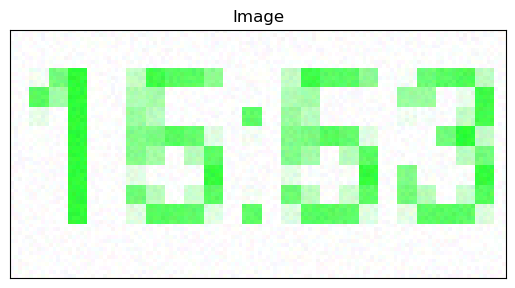

Predicted Time: 15:53


In [ ]:
visualize(image=image)
print("Predicted Time:", predicted_time)

## [Task 10] Model Evaluation - 1 Point

### Description:
Write a function to assess the model's performance on the validation set by calculating accuracy, which is the proportion of correct predictions to total predictions.

### Steps:
1. Define an `evaluate_model` function that receives the model, paths to splits and targets, and the directory containing images.
2. Load the validation set splits and corresponding targets.
3. Iterate over the validation set, performing inference and comparing the predicted time to the actual time.
4. Tally the correct predictions and calculate the accuracy.

**(!!) To achieve full points for this task, the model's accuracy on the validation set must exceed 0.9. Make sure to fine-tune your model and preprocessing steps to meet this benchmark.**

**Two helper functions, special for you:**

In [ ]:
def load_splits(splits_path: str) -> dict:
    """
    Loads train/validation splits from a JSON file.

    This function reads a JSON file specifying which images are in the training set
    and which are in the validation set.

    Args:
        splits_path (str): The path to the JSON file containing the train/validation splits.

    Returns:
        dict: A dictionary with keys 'train' and 'validation', each mapping to a list of image names.
    """
    with open(splits_path, 'r') as file:
        splits = json.load(file)
    return splits


def load_targets(targets_path: str) -> dict[str, str]:
    """
    Loads target time labels for images from a file.

    This function reads a file where each line contains a time label and an image name,
    separated by ' -> '. It creates a dictionary mapping from image names to their corresponding
    time labels.

    Args:
        targets_path (str): The path to the file containing the image names
        and their corresponding time labels.

    Returns:
        dict[str, str]: A dictionary where keys are image names
        and values are their corresponding time labels.
    """
    targets = {}
    with open(targets_path, 'r') as file:
        for line in file:
            time_str, image_name = line.strip().split(' -> ')
            targets[image_name] = time_str
    return targets

In [ ]:
import json
import os


def evaluate_model(
    model: torch.nn.Module,
    splits_path: str,
    targets_path: str,
    images_dir: str,
    image_size: int = 64
) -> float:
    """
    Evaluates model's accuracy on a validation set.

    This function calculates the accuracy of the provided model by comparing its predictions
    with the actual target times for each image in the validation set. It uses a specified
    splits file to determine the images in the validation set and a targets file to get the
    correct time labels.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        splits_path (str): Path to the JSON file containing the train/validation splits.
        targets_path (str): Path to the file containing the image names and their corresponding time labels.
        images_dir (str): Directory containing the images referenced in the targets file.
        image_size (int, optional): Size to which the images should be resized.

    Returns:
        float: The accuracy of the model on the validation set.
    """
    model.eval()
    splits = load_splits(splits_path)
    targets = load_targets(targets_path)

    # Metrics initialization
    correct_predictions = 0
    total_predictions = 0

    # Evaluate on the validation set
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Calculate accuracy
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
    return accuracy

splits_path = 'timer_dataset/splits.json'
targets_path = 'timer_dataset/targets.txt'
images_dir = 'timer_dataset/images/'

accuracy = evaluate_model(model, splits_path, targets_path, images_dir)
print("\nAccuracy:", accuracy)

In [ ]:
assert accuracy > 0.9, "Try again!"

## [Task 11] Model Conversion and Speed Benchmarking - 1 Point

### Description:
Convert the trained model to different runtimes (JIT, ONNX, TensorRT) and benchmark the inference speed. Document the results in a comparative table.

### Steps:
1. Use the original PyTorch model (referred to as 'Vanilla') and perform inference speed testing.
2. Convert the model using JIT compilation and measure the inference speed.
3. Use the Torch Compile API to compile the model and benchmark the speed.
4. Convert the model to TensorRT and test inference speed.
5. Convert the model to ONNX and test inference speed.

**Vanilla**

In [ ]:
# Ensure, that the model in eval() mode, put it on the device
model = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

In [ ]:
%%timeit -n 500
image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
infer_torch(image, model)

**Jit Tracing**

Torch JIT tracing converts PyTorch models into an optimized, platform-independent format, boosting performance and simplifying deployment. It's useful for efficiently running models across different devices.

In [ ]:
# Create a dummy input for the tracing
# ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

# Trace the model
# ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

In [ ]:
%%timeit -n 500
image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
infer_torch(image, traced_model)

**Torch Compile**

`torch.compile` is a PyTorch feature that enhances performance by JIT-compiling PyTorch code into optimized kernels. This method speeds up code execution significantly with minimal changes to the existing codebase. It's a step beyond previous PyTorch compiler solutions like TorchScript and FX Tracing, offering more streamlined and efficient optimization.

In [ ]:
# Compile the model
opt_model = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

In [ ]:
%%timeit -n 500
image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
infer_torch(image, opt_model)

**TensorRT**

`TensorRT`, developed by NVIDIA, significantly enhances the speed and efficiency of deep learning models on GPUs. It uses advanced optimization techniques such as layer fusion and precision calibration to maximize throughput and reduce latency. Designed for cross-platform compatibility, it supports various frameworks and is particularly effective in production environments where high-performance inference is crucial.

In [ ]:
import torch_tensorrt

# Create a dummy input for the compile
dummy_input = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

# Compile the model
tensorrt_model = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

In [ ]:
%%timeit -n 500
image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
infer_torch(image, tensorrt_model)

**ONNX**

`ONNX (Open Neural Network Exchange)` is an open format designed to represent machine learning models. It enables models to be transferred between different frameworks, ensuring interoperability and flexibility. ONNX is widely used for model sharing and deployment across various platforms and tools, making it valuable for developers working in diverse environments or with multiple machine learning frameworks. Its ability to standardize model representation simplifies the process of model exchange and deployment.

In [ ]:
import torch
import torch.onnx

# Create a dummy input for the export
dummy_input = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

# Export the model, saving it like "model.onnx"
# ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

In [ ]:
import numpy as np
import onnxruntime as ort


def infer_onnx(
    image: np.ndarray,
    session: ort.InferenceSession,
    image_size: int = 64
  ) -> str:
    """
    Performs inference on a single image using an ONNX model session.

    This function applies validation augmentations and preprocessing to the image, converts it to the
    format expected by the ONNX model, and then uses the session to predict the time. The function
    outputs the predicted time as a string.

    Args:
        image (np.ndarray): The image to be processed and fed into the ONNX model.
        session (ort.InferenceSession): The ONNX model inference session.
        image_size (int, optional): The size to which the image will be resized.

    Returns:
        str: The predicted time as a string in the format 'HH:MM'.
    """
    # Get ONNX model input_name
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Apply validation augmentations
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Preprocess the image
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Convert the image to the batch expected by ONNX, cast to float
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Predict using the ONNX session
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Assuming the model returns two outputs: hour and minute
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE

    # Convert to time format
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
    return time_str

In [ ]:
# We initialize a session first
session = ort.InferenceSession("model.onnx")

In [ ]:
%%timeit -n 500
image = # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ YOUR CODE HERE
infer_onnx(image, session=session)

### Fill the table:

| Runtime   | Number of Loops | Mean Inference Time (ms) | Standard Deviation (ms) |
|-----------|-----------------|--------------------------|-------------------------|
| Vanilla   | 500             | TBD                      | TBD                     |
| JIT       | 500             | TBD                      | TBD                     |
| Compile   | 500             | TBD                      | TBD                     |
| TensorRT  | 500             | TBD                      | TBD                     |
| ONNX      | 500             | TBD                      | TBD                     |

### Your comments on results:

(0_0)

## [Task 12] Rust - 3 Points

<img src="./images/4.jpeg" width=50%>

### About Rust:
Rust is a programming language known for its focus on safety and performance. It's designed to be memory safe, preventing common bugs seen in languages like C and C++. Rust achieves this through its unique ownership system, which manages memory and other resources at compile time, eliminating many runtime errors.

Its performance is comparable to C++, making it suitable for systems programming and applications where speed is critical. Rust also offers modern features like zero-cost abstractions, guaranteed memory safety, and a friendly compiler with useful error messages, enhancing developer experience.

Rust is increasingly popular in areas such as web assembly, embedded systems, and networking, as well as for building command-line tools and desktop applications. Its growing community and rich ecosystem of tools and libraries contribute to its rising adoption.


### Suggested Materials:
- "Rust by Example": A collection of runnable examples that illustrate various Rust concepts and standard libraries.
- "Rustlings": A fun, instructive way to get accustomed to reading and writing Rust syntax through small exercises.
- "Maturin": A tool specifically designed for creating Python extensions in Rust with ease. It integrates seamlessly with Cargo and PyPI, simplifying the process of building and distributing Rust-written Python modules. Ideal for enhancing Python with Rust’s performance and safety features, Maturin makes it straightforward to package and share Rust code as Python packages.

### Why Infer in Rust:
Rust is good for machine learning inference, offering safety and high performance. It avoids latency issues common with garbage collectors and its type system and concurrency model enable efficient, maintainable code. Rust's capabilities allow for serverless inference with lightweight binaries, addressing the slowness of large frameworks like PyTorch in cluster instances. It also reduces Python's performance overhead, a notable advantage given Python's Global Interpreter Lock (GIL) challenges. Rust's growing popularity in the machine learning ecosystem.

Finally, Rust is cool!

---

### Description:
The task involves enhancing a machine learning workflow by integrating Rust's performance capabilities with Python's flexibility. The goal is to use Rust for running an ONNX model inference, and then create Python bindings to utilize the Rust implementation. This hybrid approach aims to leverage Rust's performance and safety while maintaining the ease of use provided by Python.

The project structure includes:
```
.
├── Cargo.toml
├── images
├── HW6.ipynb
├── model.onnx
├── example.png
├── src
│   ├── lib.rs
│   └── main.rs
└── timer_dataset
```

- An example image file `example.png` which could be used for testing the inference process.
- A `model.onnx` file which is our converted model to be used for inference.
- A `Cargo.toml` file indicating the Rust project's dependencies.
- A source directory `src` containing the Rust source code:
  - `lib.rs` which is a Rust library file containing shared logic or definitions.
  - `main.rs` which is the Rust main file, containing the entry point of the Rust application.

**The `.rs` files in the source directory are almost complete but contain errors that need to be fixed. After correcting these errors, you are expected to compile the Rust source into a binary. This binary will be a production-ready executable that performs the ONNX model inference.**

**The second part of the task is to build Python bindings using `maturin`. These bindings will allow Python scripts to call the Rust binary and perform inference. The binding should provide an interface where Python code can pass the paths of the model and image files, and then receive the inference results. The results expected are a string representing the predicted outcome and a float64 value indicating the elapsed time of the model call in Rust.**

### Steps:
1. Debug and correct the Rust code provided in `.rs` files.
2. Compile the corrected Rust code into a production-ready binary for ONNX model inference.
3. Create Python bindings for the Rust binary to allow inference from Python, ensuring the binding returns the predicted time as a string and the elapsed time as a float64.

### Part 1: Binary - 1 Point

Compile a Rust binary that performs ONNX model inference and accurately predicts time from an image.

Instructions:
1. Compile the Rust binary using the provided command. Ensure all dependencies are correctly installed for a successful build.
2. Run the binary with an image to perform inference. The program should output the time taken for inference and the predicted time.

Criteria for Full Points:
 - The Rust binary compiles without errors.
 - Upon execution, the binary prints out the time taken for the inference process and the correct predicted time.

In [ ]:
!cargo build --bin binary -r

In [ ]:
!./target/release/binary

### Part 2: Python Binding - 2 Points

Build a Python binding for the Rust-based ONNX inference engine and validate its functionality through a Python interface.

Instructions:
1. Use maturin to build the Python binding from the Rust implementation.
2. Install the generated wheel using pip to make the binding available to Python.
3. In Python, import the provided binding function and pass the paths of the ONNX model and an image file to it.
4. Check that the function returns the correct prediction and the model's call time measured in Rust.

Criteria for Full Points:
 - The Python binding compiles and installs without errors.
 - The Python code successfully calls the Rust inference engine and returns the correct prediction and elapsed time.

**Binding build and library install:**

In [ ]:
!maturin build -r

In [ ]:
!pip install # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Binding test:**

In [ ]:
from onnx_inference import run_model

In [ ]:
predict, elapsed_time = run_model("model.onnx", "example.png")

In [ ]:
print("Time:", predict, "\nElapsed time:", elapsed_time)

In [ ]:
assert predict == "15:53"